## Постановка задачи:

Реализовать алгоритм получения файла с генетическими вариантами (формат VCF, достаточно первых пяти столбцов) для заданного SAM файла и референсной последовательности в формате FASTA.

Для упрощения можно считать однонуклеотидным полиморфизмом нуклеотид, встречающийся более чем в 20% коротких прочтений и не менее чем 2 раза.

## Теормин:

***генетический вариант*** - термин для описания подтипа микроорганизма, который генетически отличается от основного штамма, но недостаточно отличается, чтобы его можно было назвать отдельным штаммом(как сорт)

***референсная(эталонная) последовательность*** - цифровая база данных последовательностей нуклеиновых кислот, собранная учеными как репрезентативный пример набора генов в одном идеализированном индивидуальном организме вида(для человека использовали участки генома 60 особей)

***конвейер биоинформатики*** представляет собой набор связанных алгоритмов (или блоков), которые выполняются в заранее определенном порядке для обработки и анализа данных NGS

Например участок конвейера может выглядеть так:
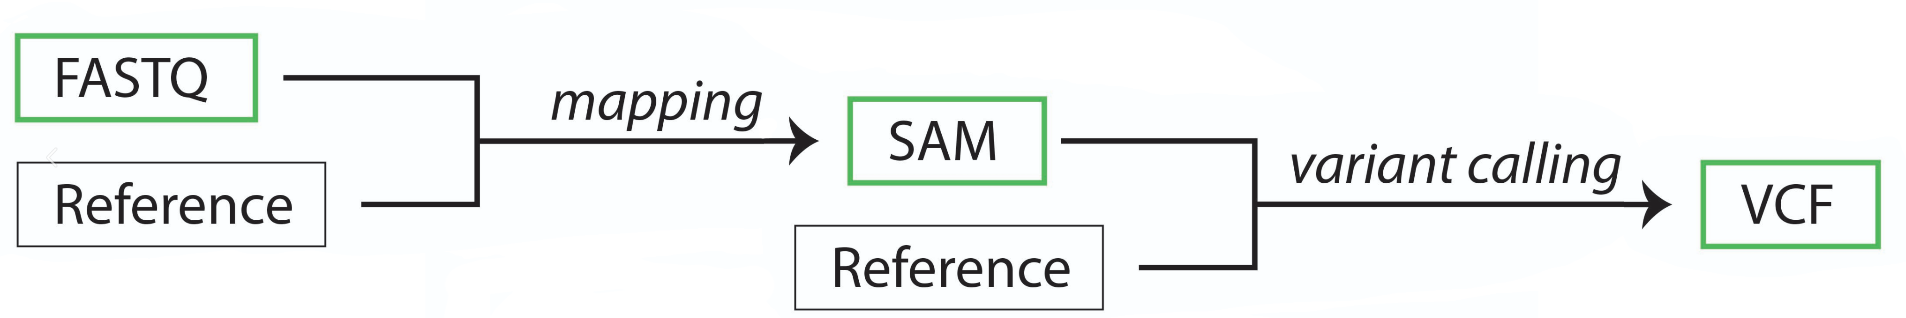


***FASTA*** - текстовый формат для нуклеотидных или полипептидных последовательностей, в котором нуклеотиды или аминокислоты обозначаются при помощи однобуквенных кодов

***SAM*** - это текстовый формат, изначально предназначенный для хранения биологических последовательностей, выровненных по эталонной последовательности

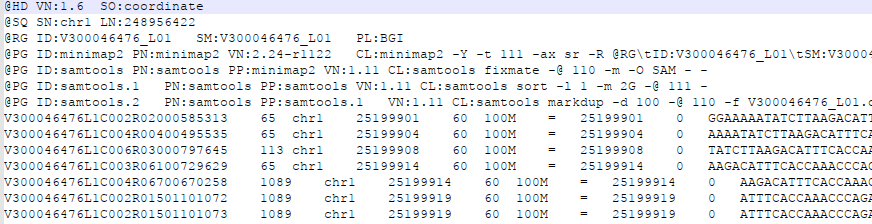

***VCF(Variant Call Format)*** - формат текстового файла, используемый в биоинформатике для хранения вариаций последовательности генов

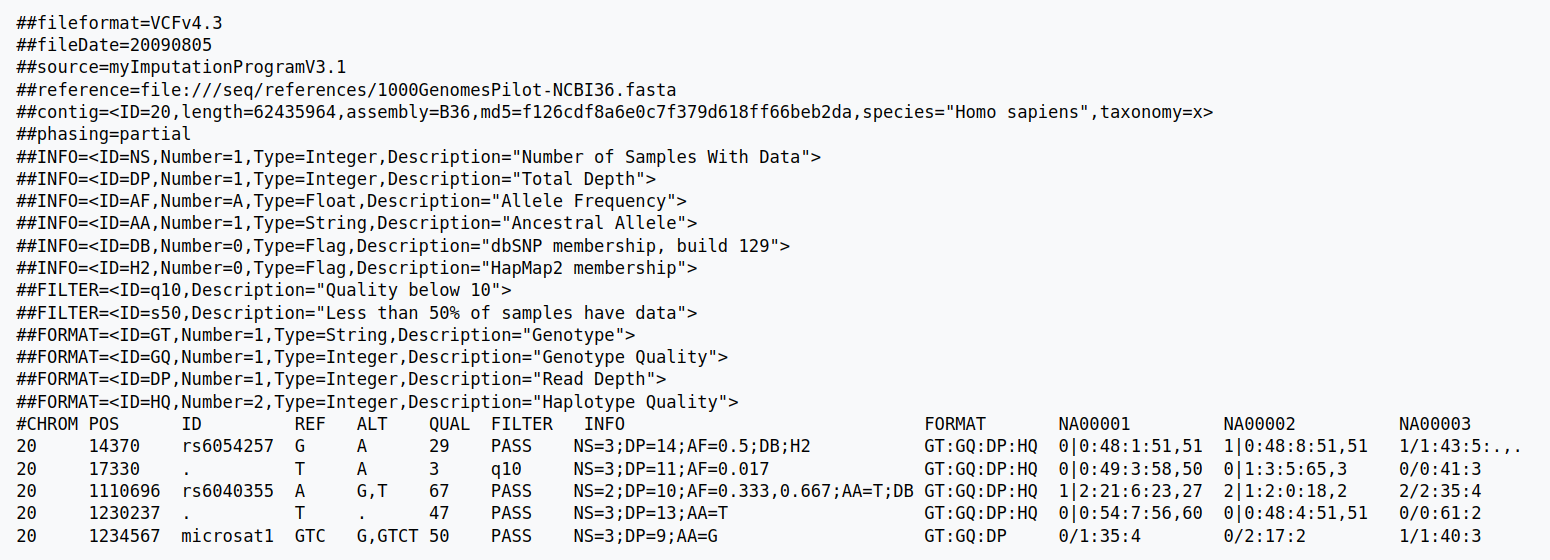

***однонуклеотидный полиморфизм(SNP)*** - отличия последовательности ДНК размером в один нуклеотид в геноме представителей одного вида или между гомологичными участками гомологичных хромосом, возникают в результате точечных мутаций


In [57]:
import sys
from datetime import date
import pysam

def find_chrom(genome, chrom):
    genome.seek(0, 0)
    line = genome.readline()
    while line:
        if chrom in line:
            return 0
    return 1

def edit_fasta(fname, chroms):
    f = open(fname, 'r')
    something_large = f.read()
    something_large.replace('\n', '')
    tmp_name = "tmp.fasta"
    tmp = open(tmp_name, "w+")
    tmp.write(something_large)
    f.close()
    tmp.close()
    pos1 = something_large.find('>')
    while pos1 != -1:
        pos2 = something_large.find(':')
        i = pos2
        while something_large[i] not in 'ACTG':
            i += 1
        n1, n2 = list(map(int, something_large[pos2 + 1:i].split('-')))
        chroms[something_large[pos1 + 1:pos2]] = [i, n1, n2]
        something_large = something_large[i:]
        pos1 = something_large.find('>')
    return tmp_name

def type_variant(str1, str2):
    pos, ref, alt = '.', '.', '.'
    # for i, j in zip(str1, str2):
    i = 0
    lenn = min(len(str1), len(str2))
    while i < lenn:
        if str1[i] != str2[i]:
            if i + 1 < lenn and str1[i + 1] == str2[i + 1]: #replace
                pos = i + 1
                ref = str1[i]
                alt = str2[i]
            elif i + 1 < lenn and str2[i] == str1[i + 1]: # delete
                pos = i 
                ref = str1[i - 1:i + 1]
                alt = str1[i - 1]
            elif i + 2 < lenn and str1[i + 1] == str2[i + 2]: # insert
                pos = i 
                ref = str1[i - 1:i + 1]
                alt = str1[i - 1:i + 2]
            break
        i += 1
    return [pos, ref, alt]
    
    

CUR_VCF_VER = '4.4'

#if len(sys.argv) < 3:
#    sys.exit("Еnter the source files")
sys.argv[1] = 'test.sam'
sys.argv[2] = 'test.fa'
    
vcf_res = open("output.vcf", "w+")
vcf_res.write('##fileformat=VCFv' + CUR_VCF_VER + '\n')
vcf_res.write('##fileDate=' + str(date.today()).replace('-', '') + '\n')
vcf_res.write('##source=' + sys.argv[0] + '\n')
vcf_res.write('##reference=' + sys.argv[2] + '\n')
# SOMETHING...
vcf_res.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\n')

sam_src = pysam.AlignmentFile(sys.argv[1], 'rb')
chr = dict()
fasta_src = open(edit_fasta(sys.argv[2], chr))
for rec in sam_src:
    cur_chr = sam_src.getrname(rec.reference_id)
    vcf_res.write(cur_chr + '\t')
    if rec.reference_start  < chr[cur_chr][1]:
        vcf_res.write('.\t.\t.\t.')
        continue
    fasta_src.seek(chr[cur_chr][0] + rec.reference_start - chr[cur_chr][1], 0)
    ref_section = fasta_src.read(rec.reference_end - rec.reference_start)
    #print('shift: ', rec.reference_start ,  chr[cur_chr][1])
    lst = type_variant(ref_section, rec.query_sequence) # need cigar?
    vcf_res.write(str(lst[0]) + '\t.\t' + str(lst[1]) + '\t' + str(lst[2]) + '\n')
vcf_res.close()
fasta_src.close()

[W::sam_parse1] unrecognized mate reference name "chr14"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr14"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr7"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr5"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr20"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chrX"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr3"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr2"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr17"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr2"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr14"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr7"; treated as unmapped
[W::sam_parse1] unrecognized mate reference name "chr11"; treated as un

## Проверка алгоритма

samtools view -bS input.sam > output.bam
   
samtools sort -o output_sorted.bam output.bam
samtools index output_sorted.bam

bcftools mpileup -Ou -f reference.fasta output_sorted.bam | bcftools call -mv -o variants.vcf

и другие утилиты заполяют только хедер =(